#### **Import necessary libraries**

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score

import joblib

#### **Functions**

In [78]:
def plot_residuals(y_test, y_pred, title="Residuals vs. Fitted Values"):
    """
    Plots residuals vs. fitted values for regression models.
    """
    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### **Load Data**

In [79]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

In [80]:
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,5,17,3,1,1,197.640,0
1,0,0,39,0,318,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,2,33,1,1,1,145.805,0


#### **Input and Target Features**

In [81]:
X = df.drop(columns=["customer_value", "churn"])
y = df["customer_value"]

In [82]:
y_log = np.log1p(y)

#### **Numeric and Categorical features**

In [83]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "subscription_length"
]
categorical_features = [ "tariff_plan", "age_group", "status"]

#### **Base Model**

In [84]:
# 1. Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

In [85]:
# 2. Pipeline
baseline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])


In [86]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [87]:
# 4. Fit & predict
baseline_rf.fit(X_train, y_train)
y_pred = baseline_rf.predict(X_test)

#### **Evaluate Base Model**

#### RMSE and R2

In [88]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regression Model - RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")


Regression Model - RMSE: 0.08, R2 Score: 0.9950


- The R² score of 0.9950 indicates the model explains 99.5% of the variance in the data
- The very low RMSE (0.08) confirms the model's predictions are highly accurate

#### Plot residuals vs fitted

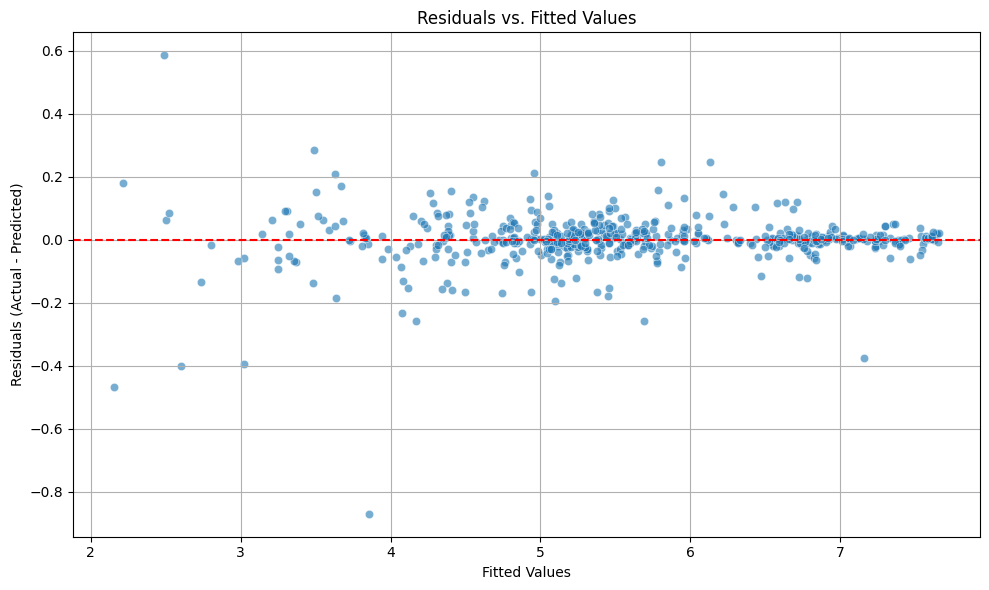

In [89]:
plot_residuals(y_test, y_pred, "Residuals vs. Fitted Values")

- The points are fairly evenly scattered around the zero line, indicating good model fit.
- Most residuals fall within ±0.25 range, with only a few outliers beyond these bounds.

#### **Cross Validation**

In [90]:
# Reuse the same pipeline
neg_rmse_scores = cross_val_score(baseline_rf, X, y_log, scoring='neg_root_mean_squared_error', cv=5)
r2_scores = cross_val_score(baseline_rf, X, y_log, scoring='r2', cv=5)

print(f"\nCross-validated RMSE scores: {-neg_rmse_scores}")
print(f"Average RMSE: {-neg_rmse_scores.mean():.2f}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average R2: {r2_scores.mean():.4f}")


Cross-validated RMSE scores: [0.06296145 0.08426806 0.08143831 0.0816784  0.10331074]
Average RMSE: 0.08
Cross-validated R2 scores: [0.99705752 0.99534573 0.99572246 0.99497799 0.99151894]
Average R2: 0.9949


#### **Evaluate Cross Validated Model**

The cross-validation results show excellent model performance:

- Very low Root Mean Square Error (RMSE) with an average of 0.08, indicating the model's predictions are very close to actual values
- Exceptional R-squared (R2) score averaging 0.9949, meaning the model explains about 99.49% of the variance in the data

The consistency across different cross-validation folds suggests the model is robust and generalizes well to unseen data.

#### Plot residuals vs fitted

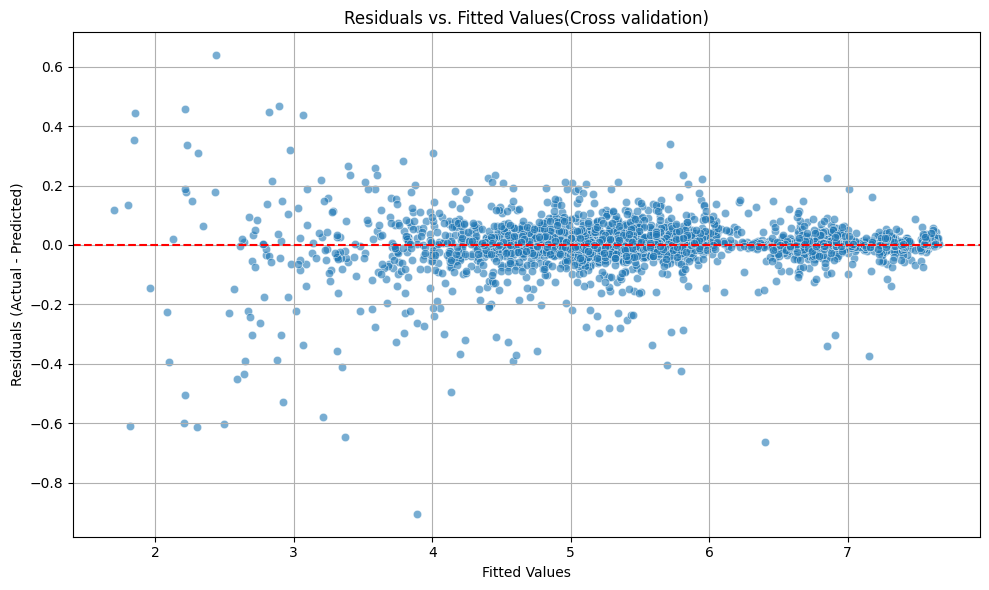

In [91]:
from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions
y_pred_cv = cross_val_predict(baseline_rf, X, y_log, cv=5)

# Plot residual
plot_residuals(y_log, y_pred_cv, "Residuals vs. Fitted Values(Cross validation)")

- The residuals are mostly clustered around the zero line, indicating generally good predictions
- Most residuals fall within ±0.5 range, with a few outliers reaching ±1.0
- The spread of residuals is fairly consistent across different CLV values suggesting homoscedasticity
- There's slightly more variance in residuals for lower CLV values (1-3) compared to higher values

This confirms the strong cross-validation performance, though with slightly higher error than the single test split.

In [92]:
residuals_cv = y_log - y_pred_cv

##### Histogram (log residuals)

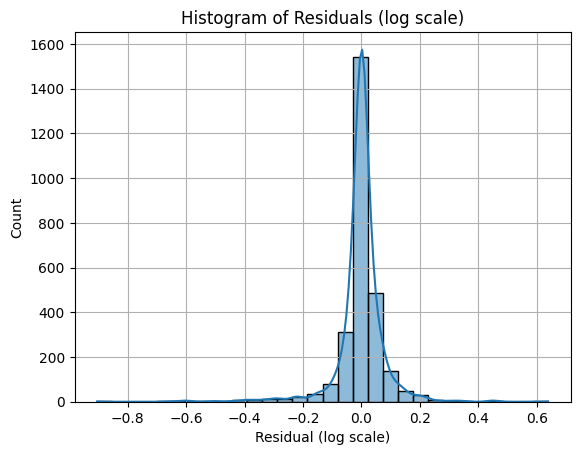

In [93]:
sns.histplot(residuals_cv, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()

- A strong normal distribution centered around zero, indicating well-balanced prediction errors
- Most residuals are tightly clustered between -0.2 and 0.2, showing high prediction accuracy
- Very few extreme residuals beyond ±0.5, with almost none reaching ±1.0
- The symmetric shape suggests the model is not systematically over- or under-predicting

This distribution confirms the model's excellent performance in predicting Customer Lifetime Value, with most predictions being very close to actual values.

##### Scatter Plot: Actual vs. Predicted CLV (Real World)

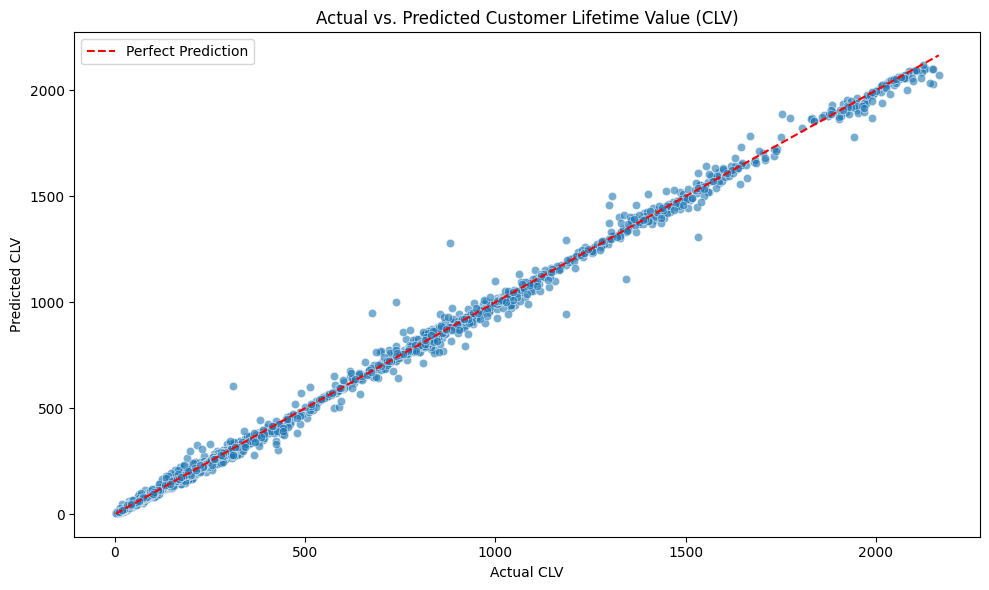

In [94]:
y_pred = np.expm1(y_pred_cv)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted Customer Lifetime Value (CLV)")
plt.legend()
plt.tight_layout()
plt.show()

The plot of Actual vs. Predicted Customer Lifetime Value (CLV):

- Points closely follow the red dashed "Perfect Prediction" line across all CLV values (0-2000).
- Very few points deviate significantly from the line, indicating consistent accuracy across the value range.
- The model performs well for both low and high CLV customers, with no systematic bias.

#### **Persist the model**

In [95]:
# Fit the pipeline on the full training data
baseline_rf.fit(X, y_log)

# Save the entire pipeline to a file
joblib.dump(baseline_rf, '../resources/models/Random_forest_regression_model_final.pkl')

['../resources/models/Random_forest_regression_model_final.pkl']